# Generate Adversarial Exemples using DQN against Rec-CNN

## Setup

Install all the dependecies, mount google drive and import modules

### Install package

In [ ]:
%pip install --no-deps 'stable-baselines3[extra]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
%pip install --no-deps sb3-contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 3.5 MB/s eta 0:00:00


### Mount drive

In [ ]:
import pathlib

try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    STORAGE = pathlib.Path("/content/drive/MyDrive") / "data"
except ImportError:
    STORAGE = pathlib.Path.cwd().resolve() / "data"
    print(f"Local storage at {STORAGE}")

Mounted at /content/drive


###  Import modules

In [ ]:
import gc
import json
import logging
import operator
import pathlib
import pickle
import platform
import random
import sys
import warnings
from datetime import datetime
from functools import reduce
from time import sleep
from traceback import print_exc
from typing import (
    Any,
    Callable,
    Optional,
    TypeAlias,
    TypedDict,
    TypeVar,
    Union,
)

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import psutil
import torch
from gymnasium import spaces
from IPython.display import Javascript
from keras import Sequential, saving
from matplotlib import ticker
from numpy.typing import NDArray
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import OrdinalEncoder
from stable_baselines3 import A2C, DQN, PPO  # noqa: F401
from stable_baselines3.common.vec_env import (
    VecEnv,
    VecEnvWrapper,
    VecMonitor,
)
from stable_baselines3.common.vec_env.base_vec_env import (
    VecEnvIndices,
    VecEnvObs,
    VecEnvStepReturn,
)
from torch import nn
from typing_extensions import Protocol

warnings.simplefilter(action="ignore", category=DeprecationWarning)
from tqdm.auto import tqdm as tqdm_auto  # noqa: E402
from tqdm.rich import tqdm_rich  # noqa: E402

### Show computer information

In [ ]:
GB = 1024**3
gpu_available = torch.cuda.is_available()
print("GPU Available:", gpu_available)
if gpu_available:
    gpu_properties = torch.cuda.get_device_properties(0)
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    print(f"Total GPU Memory: {gpu_properties.total_memory / GB:.1f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Python: {sys.version}")
print(f"System: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)}")
print(f"Logical CPUs: {psutil.cpu_count(logical=True)}")
print(f"Total RAM: {psutil.virtual_memory().total / GB:.1f} GB")

GPU Available: True
GPU Name: NVIDIA L4
CUDA Version: 12.4
GPU Capability: (8, 9)
Total GPU Memory: 22.2 GB
Number of GPUs: 1
Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
System: Linux 6.1.123+
Processor: x86_64
CPU Cores: 6
Logical CPUs: 12
Total RAM: 53.0 GB


### Declare constants

In [ ]:
# Printing options
np.set_printoptions(threshold=1000)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(
    action="ignore",
    message="The environment is already wrapped with a `Monitor` wrapper.*",
    category=UserWarning,
)
warnings.filterwarnings(
    action="ignore", message="You are trying to run .*", category=UserWarning
)
logging.basicConfig(level=logging.INFO, force=True)
logger = logging.getLogger(__name__)

# Detection model threshold
THRESHOLD = 0.5

# Seed of the notebook
SEED = 42

# Path to the notebook
HERE = pathlib.Path().parent

# Types
MaskNDArray: TypeAlias = npt.NDArray[np.int8]
Obs: TypeAlias = NDArray[np.int8]
Act = np.int64
T = TypeVar("T")


class AbstractModel(Protocol):
    def predict(
        self,
        observation: Union[np.ndarray, dict[str, np.ndarray]],
        state: Optional[tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False,  # noqa: FBT001, FBT002
    ) -> tuple[np.ndarray, Optional[tuple[np.ndarray, ...]]]:
        """Predict if malicious or benign based on observation."""
        ...

## Model

### Parameters

You can configure the model and environnement below.

In [ ]:
parameters = {
    "data": {
        "test_size": 0.2,
    },
    "env": {
        "n_envs": 64,
        "frame": 128,
        "max_timesteps": 1024,
        "attack": "0316",
        "attack_reward": 2,
        "control_reward": 1,
        "alive_reward": 64,
        "survive_reward": 4,
        "noise_penalty": 5,
        "detected_penalty": 128,
        "error_penalty": 64,
        "allow_noise": False,
    },
    "model": {
        "n_steps": 128,
        "policy_kwargs": {
            "net_arch": [256, 256],
            "activation_fn": "relu",
            "normalize_images": False,
        },
    },
    "train": {
        "total_timesteps": 500_000,
    },
    "monitor": {
        "info_keywords": (
            "control_duration",
            "duration",
            "attack_count",
            "control_count",
            "noise_count",
            "step",
            "max_timesteps",
            "max_duration",
            "num_timesteps",
            "attack_reward",
            "survive_reward",
            "noise_reward",
            "detected_reward",
            "error_reward",
            "control_reward",
            "alive_reward",
            "false_positive_count",
            "true_positive_count",
            "false_negative_count",
            "true_negative_count",
        )
    },
}

### Functions

In [ ]:
def fb_score(b: float, x: float, y: float) -> float:
    """Compute the F Beta Score.

    ref: https://en.wikipedia.org/wiki/F-score
    """
    bottom = (b**2 * x) + y
    if bottom == 0:
        return 0
    return (1 + b**2) * x * y / ((b**2 * x) + y)


def score(info: dict[str, float]) -> float:
    """Compute the F5-Score using a domination and survivability.

    ref: https://en.wikipedia.org/wiki/F-score
    """
    domination = info["control_count"] / info["step"]
    survivability = info["step"] / info["max_timesteps"]
    return fb_score(
        5,
        domination,
        survivability,
    )


def remove_last_figure() -> None:
    """Remove the last figure from the notebook."""
    display(
        Javascript("""
        var figures = document.querySelectorAll('.output_subarea');
        if (figures.length > 0) {
            figures[figures.length - 1].remove();
        }
    """)
    )


def close_all_tqdm() -> None:
    """Close all tqdm rich."""
    sleep(1)
    gc.collect()
    for obj in gc.get_objects():
        if issubclass(type(obj), tqdm_rich):
            try:
                obj.close()
                obj.disable = True
            except AttributeError:
                pass
    sleep(1)


def rolling(series: pd.Series, window: Optional[int] = None) -> pd.Series:
    """Flatten the curve."""
    if window is None:
        window = min((len(series) // 100) * 2 + 5, len(series))
    return series.rolling(window=window).mean()


def add_exploration_line(parameters: dict[str, Any]) -> None:
    """Add line for exploration."""
    if "exploration_fraction" in parameters["model"]:
        exploration = (
            parameters["train"]["total_timesteps"]
            * parameters["model"]["exploration_fraction"]
        )
        plt.axvline(
            x=exploration, color="darkred", linewidth=1, linestyle="--"
        )
    if "exploration_final_eps" in parameters["model"]:
        final_eps = parameters["model"]["exploration_final_eps"]
        plt.axhline(y=final_eps, color="darkred", linewidth=1, linestyle="--")


activations = {"relu": nn.ReLU, "sigmoid": nn.Sigmoid}

### Dataset

In [ ]:
class Dataset:
    def __init__(
        self, dataset: pd.DataFrame, encoder: Optional[OrdinalEncoder] = None
    ) -> None:
        """Initialize the dataset."""
        if encoder is None:
            encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            )
            encoder.fit(dataset[["Arbitration_ID"]])
        self.encoder = encoder
        self.encoder_size = (
            reduce(
                operator.mul, (len(cat) for cat in self.encoder.categories_)
            )
            + 1
        )
        self._dataset = dataset
        self._state = self.flatten_categorical_one_hot_encode(self._dataset)

    @classmethod
    def load_train(
        cls, dataset_path: pathlib.Path, test_size: float = 0.2
    ) -> None:
        """Load train dataset."""
        dataset = pd.read_parquet(dataset_path)
        sep = len(dataset) - int(len(dataset) * test_size)
        return Dataset(dataset[:sep].reset_index())

    @classmethod
    def load_test(
        cls,
        dataset_path: pathlib.Path,
        encoder_path: pathlib.Path,
        test_size: float = 0.2,
    ) -> None:
        """Load test dataset and the according encoder."""
        dataset = pd.read_parquet(dataset_path)
        encoder = pickle.loads(encoder_path.read_bytes())  # noqa: S301
        sep = len(dataset) - int(len(dataset) * test_size)
        return Dataset(
            dataset[:sep].reset_index(),
            encoder,
        )

    def get_frame(self, index: str, size: int = 1) -> pd.DataFrame:
        """Get the network frame at the given index."""
        return self._dataset.iloc[index : index + size][
            ["Timestamp", "Arbitration_ID"]
        ]

    def pandas(self) -> pd.DataFrame:
        """Get the network frame at the given index."""
        return self._dataset

    def get_state(self, index: str, size: int = 1) -> Obs:
        """Get the state frame at the given index."""
        return self._state[
            index * self.encoder_size : (index + size) * self.encoder_size
        ]

    def flatten_categorical_one_hot_encode(
        self,
        network_frame: pd.DataFrame,
    ) -> NDArray[np.int8]:
        """Perform a one hot encoding and flatten the result."""
        ordinal_ids = (
            self.encoder.transform(network_frame[["Arbitration_ID"]])
            .astype(np.int32)
            .flatten()
            + 1  # Turn -1 into 0
        )
        one_hot = np.zeros(
            (len(ordinal_ids), self.encoder_size),
            dtype=np.int8,
        )
        one_hot[np.arange(len(ordinal_ids)), ordinal_ids] = 1
        return one_hot.flatten()

    def random_index(
        self, frame_size: int, duration: int, seed: Optional[int]
    ) -> int:
        """Get a random index from the dataset."""
        rand = random.Random(seed)  # noqa: S311
        # Get an index where the simulation will start
        return rand.randrange(frame_size, len(self._dataset) - duration)

### RecCNN

In [ ]:
def recurrence_plot(
    s: NDArray[np.int8],
) -> NDArray[np.int8]:
    """Create recurrence plot with step at 1 and epsilon at > 0."""
    distance_matrix = s[None, :] - s[:, None]
    return np.rot90(np.array(distance_matrix != 0, dtype=np.int8))


class RecCNN:
    def __init__(
        self, model_path: pathlib.Path, encoder_path: pathlib.Path
    ) -> None:
        """Initialize the model."""
        if not model_path.exists() or not encoder_path.exists():
            raise FileNotFoundError
        # https://github.com/keras-team/keras/issues/9964
        # https://github.com/Dref360/tuto_keras_web/blob/master/keras_model.py
        self.model: Sequential = saving.load_model(model_path, compile=False)
        self.encoder: OrdinalEncoder = pickle.load(  # noqa: S301
            encoder_path.open("rb")
        )

    def _prepare_batches(
        self, frames: list[pd.DataFrame], verbose: str = "0"
    ) -> npt.NDArray[np.int8]:
        images = []
        for frame in tqdm_auto(frames, disable=verbose == "0"):
            unique_ids = self.encoder.transform(frame[["Arbitration_ID"]])
            img3d = np.stack(
                [np.rot90(unique_ids != unique_ids.T)] * 3, axis=-1
            )
            images.append(img3d)
        return np.stack(images, axis=0, dtype=np.int8)  # (X, 128, 128, 3)

    def predict_batches(
        self, frames: list[pd.DataFrame], verbose: str = "0"
    ) -> npt.NDArray[np.float32]:
        """Predict the current frame."""
        batch = self._prepare_batches(frames)
        return self.model.predict(
            batch, verbose=verbose, batch_size=len(frames)
        )[:, 0]

    def predict(self, frame: pd.DataFrame) -> float:
        """Predict the current frame."""
        return float(self.predict_batches([frame])[0])

### Insights

In [ ]:
def compute_insights(df: pd.DataFrame) -> None:
    """Compute all insights."""
    df["control"] = df["control_count"] / df["max_timesteps"]
    df["domination"] = (df["control_count"] / df["step"]).fillna(0)
    df["survivability"] = df["step"] / df["max_timesteps"]
    df["impact"] = 1 - (df["attack_count"] / df["control_count"]).fillna(1)
    df["impact_count"] = (df["control_count"] / df["attack_count"]).fillna(0)
    df["aggressivity"] = (df["attack_count"] / df["step"]).fillna(0)
    df["noise"] = (df["noise_count"] / df["step"]).fillna(0)
    df["inactivity"] = 1 - df["aggressivity"] - df["noise"]
    df["score"] = df.apply(lambda x: score(x), axis=1)

    # COmpute reward ration
    df["reward_ratio"] = (
        (df["r"] - df["r"].min()) / (df["r"].max() - df["r"].min())
    ).fillna(0)
    df["attack_reward_ratio"] = (df["attack_reward"] / df["r"]).fillna(0)
    df["survive_reward_ratio"] = (df["survive_reward"] / df["r"]).fillna(0)
    df["detected_reward_ratio"] = (df["detected_reward"] / df["r"]).fillna(0)
    df["control_reward_ratio"] = (df["control_reward"] / df["r"]).fillna(0)
    df["alive_reward_ratio"] = (df["alive_reward"] / df["r"]).fillna(0)

    # Compute rates
    df["false_count"] = df["true_negative_count"] + df["false_positive_count"]
    df["true_count"] = df["true_positive_count"] + df["false_negative_count"]
    df["FPR"] = df["false_positive_count"] / df["false_count"]
    df["TNR"] = df["true_negative_count"] / df["false_count"]
    df["FNR"] = df["false_negative_count"] / df["true_count"]
    df["TPR"] = df["true_positive_count"] / df["true_count"]
    return df.fillna({"FNR": 1.0, "TPR": 0.0})


class Insights:
    def _init(self) -> None:
        if not hasattr(self, "handle"):
            self.fig, self.ax = plt.subplots(figsize=(16, 9))
            self.handle = display(self.fig, display_id=True)

    # Plotting x vs. y using the index of the DataFrame
    def plot(self, df: pd.DataFrame, *, log: bool = False) -> None:
        """Plot all insights."""
        self._init()

        def plot(
            column: str,
            color: str,
            label: Optional[str] = None,
            linestyle: str = "solid",
        ) -> None:
            if len(df) == 0:
                return
            if label is None:
                label = column.title().replace("_", " ")
            self.ax.plot(
                df["num_timesteps"],
                rolling(df[column]),
                label=label,
                linestyle=linestyle,
                color=color,
                alpha=1,
            )

        df = compute_insights(df)

        self.ax.clear()

        plot("control", "fuchsia")
        plot("domination", "purple", linestyle="dashed")
        plot("survivability", "green")
        plot("impact", "orange")
        plot("noise", "yellow")
        plot("inactivity", "grey")
        plot("aggressivity", "red")
        plot("reward_ratio", "cyan", label="Reward")
        add_exploration_line(parameters)

        # Labels and title
        self.ax.set_xlim(0, parameters["train"]["total_timesteps"])
        self.ax.set_ylim(0, 1.0)
        self.ax.set_xlabel("Timesteps")
        if log:
            self.ax.set_title("Insights by timesteps (log scale)")
            self.ax.set_yscale("log")
        else:
            self.ax.set_title("Insights by timesteps")
        self.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))

        # Add a legend
        if len(df) != 0:
            self.ax.legend(loc="upper left")  # Placement en haut à gauche
        self.ax.grid(visible=True, which="both", linestyle="--")

        # Show the plot
        self.handle.update(self.fig)  # Met à jour l'affichage de la figure

    def close(self) -> None:
        """Close the figure."""
        if hasattr(self, "fig"):
            plt.close(self.fig)

### CanBusVecEnv

In [ ]:
class StateEnv(TypedDict):
    base_indexes: int
    relative_index: int
    network_frame: pd.DataFrame
    state: Obs
    statistics: dict[str, float]
    control: bool


class CanBusVecEnv(VecEnv):
    states: dict[int, StateEnv]

    def __init__(  # noqa: PLR0913
        self,
        dataset: Dataset,
        model: RecCNN,
        n_envs: int,
        frame: int,
        max_timesteps: int,
        attack: str,
        attack_reward: float,
        control_reward: float,
        alive_reward: float,
        survive_reward: float,
        noise_penalty: float,
        detected_penalty: float,
        error_penalty: float,
        *,
        allow_noise: bool = True,
    ) -> None:
        """Instantiate CanBusVecEnv."""
        # Enable noise usage
        self.allow_noise = allow_noise

        # Get from context
        self.model = model
        self.dataset = dataset

        # Environnement parameter
        self.frame_size = frame
        self.attack = attack
        self.max_timesteps = max_timesteps

        # Reward configuration
        self.attack_reward = attack_reward
        self.control_reward = control_reward
        self.survive_reward = survive_reward
        self.alive_reward = alive_reward
        self.detected_penalty = detected_penalty
        self.noise_penalty = noise_penalty
        self.error_penalty = error_penalty

        # Seed
        self.env_counter = 0

        # Step count
        self.__num_timesteps = 0

        # Observation space: vector of 3585 binary values (one-hot encoding)
        # And one line for malicious marker (generated by an attackers)
        # 3584 of values + 1 on control flag
        self.observation_space = spaces.MultiBinary(3585)

        if self.allow_noise:
            # Action space: Discrete, 0 for nothing, other for message of id
            self.action_space = spaces.Discrete(self.dataset.encoder_size)
        else:
            # Action space: Discrete, 0 for no attack, 1 for attack
            self.action_space = spaces.Discrete(2)

        # Default action
        self.actions: np.ndarray = np.zeros(n_envs, dtype=np.int32)

        # States
        self.states = {}

        # Encoding cache
        self._cache = {}

        # Init parent
        super().__init__(n_envs, self.observation_space, self.action_space)

    def add_line(
        self,
        i: int,
        frame_line: pd.DataFrame,
        state_line: Obs,
    ) -> None:
        """Add a line to the network frame."""
        # Add the new line
        current_state = self.states[i]
        current_state["network_frame"] = pd.concat(
            [current_state["network_frame"].iloc[1:], frame_line],
            ignore_index=True,
        )
        current_state["state"] = np.concatenate(
            [current_state["state"][self.dataset.encoder_size :], state_line]
        )

    def reset_env(self, i: int) -> Obs:
        """Reset environnement at a given index."""
        state = self.states[i] = self.states.get(i, {})
        state["relative_index"] = 0
        state["control"] = 0
        state["base_index"] = self.dataset.random_index(
            self.frame_size,
            self.max_timesteps,
            self._seeds[i] + self.env_counter if self._seeds[i] else None,
        )
        self.env_counter += 1
        start_index = state["base_index"] - self.frame_size
        state["network_frame"] = self.dataset.get_frame(
            start_index, self.frame_size
        )
        state["state"] = self.dataset.get_state(start_index, self.frame_size)

        last_message = self.dataset.get_frame(
            state["base_index"] + self.max_timesteps
        )
        max_duration = (
            last_message.iloc[0]["Timestamp"]
            - state["network_frame"].iloc[-1]["Timestamp"]
        )
        state["statistics"] = {
            "control_duration": 0.0,
            "duration": 0.0,
            "done": False,
            "alive": False,
            "detected": False,
            "error_attack": False,
            "error_idle": False,
            "attack_count": 0,
            "noise_count": 0,
            "control_count": 0,
            "step": 0,
            "max_timesteps": self.max_timesteps,
            "max_duration": max_duration,
            "num_timesteps": 0,
            "r": 0,
            # Rewards
            "attack_reward": 0.0,
            "survive_reward": 0.0,
            "detected_reward": 0.0,
            "error_reward": 0.0,
            "control_reward": 0.0,
            "alive_reward": 0.0,
            "noise_reward": 0.0,
            # Predictions
            "false_positive_count": 0,
            "true_positive_count": 0,
            "false_negative_count": 0,
            "true_negative_count": 0,
        }
        state = self.states[i]["state"]
        return np.concatenate([state, [0]])

    def reset(self) -> VecEnvObs:
        """Resets the environment to its initial state."""
        return np.array([self.reset_env(i) for i in range(self.num_envs)])

    def _attack_id(self) -> int:
        attack_df = pd.DataFrame([[self.attack]], columns=["Arbitration_ID"])
        result = self.dataset.encoder.transform(attack_df)
        return int(result[0][0]) + 1

    def step_async(self, actions: np.ndarray) -> None:
        """Start a step, store the action the action to performs."""
        self.actions = actions

    def step_wait(self) -> VecEnvStepReturn:  # noqa: C901, PLR0912, PLR0915
        """Performs a step in the environment based on the action."""
        # Initialize variable
        variables_envs = {}

        # Prepare step
        updated_envs = []
        for i in range(self.num_envs):
            state = self.states[i]
            variables_envs[i] = {}
            var = variables_envs[i]
            var["done"] = False
            var["attack_reward"] = 0.0
            var["survive_reward"] = 0.0
            var["detected_reward"] = 0.0
            var["error_reward"] = 0.0
            var["control_reward"] = 0.0
            var["alive_reward"] = 0.0
            var["noise_reward"] = 0.0
            var["action"] = self.actions[i]

            # Normalize the action
            if var["action"] != 0:
                # Generate attack from action
                if self.allow_noise:
                    # -1 is because 0 is no attack, so 1 become 0
                    action_df = pd.DataFrame(
                        [[var["action"] - 1]], columns=["Arbitration_ID"]
                    )
                    var["attack"] = self.dataset.encoder.inverse_transform(
                        action_df
                    )
                else:
                    var["attack"] = self.attack

                # Generate the new attack message
                frame_line = state["network_frame"][-2:-1].copy()
                frame_line[["Malicious"]] = True
                frame_line[["Arbitration_ID"]] = var["attack"]
                state_line = self.dataset.flatten_categorical_one_hot_encode(
                    frame_line
                )
                self.add_line(i, frame_line, state_line)
                updated_envs.append(i)

        # Check if it get detected
        if updated_envs:
            frames = [self.states[i]["network_frame"] for i in updated_envs]
            predictions = self.model.predict_batches(frames)
            for i, pred in zip(updated_envs, predictions):
                state = self.states[i]
                var = variables_envs[i]
                detected = pred < THRESHOLD
                if detected:
                    state["statistics"]["true_positive_count"] += 1
                    # If detected, stop the simulation and remove a penalty
                    var["detected_reward"] -= self.detected_penalty
                    var["done"] = True
                    if self.attack == var["attack"]:
                        var["detected_reward"] -= self.detected_penalty
                        state["statistics"]["detected"] = True
                    else:
                        var["error_reward"] -= self.error_penalty
                        state["statistics"]["error_attack"] = True

                else:
                    state["statistics"]["false_negative_count"] += 1
                    if self.attack == var["attack"]:
                        # If not detected, add a reward for attacking
                        # and start adding a bonus for each messages
                        if not state["control"]:
                            var["attack_reward"] += self.attack_reward
                            state["control"] = True
                            state["statistics"]["attack_count"] += 1
                        else:
                            var["noise_reward"] -= self.noise_penalty
                            state["statistics"]["noise_count"] += 1
                    else:
                        var["noise_reward"] -= self.noise_penalty
                        state["statistics"]["noise_count"] += 1

        # Add the new message
        for i in range(self.num_envs):
            state = self.states[i]
            var = variables_envs[i]

            # Next network message
            if not var["done"]:
                # Select the next CAN message and add it to the frame
                state["relative_index"] += 1
                next_index = state["base_index"] + state["relative_index"]
                frame_line = self.dataset.get_frame(next_index)
                state_line = self.dataset.get_state(next_index)
                self.add_line(i, frame_line, state_line)

        # Detect frames
        not_done_envs = [
            i for i in range(self.num_envs) if not variables_envs[i]["done"]
        ]
        frames = [self.states[i]["network_frame"] for i in not_done_envs]
        predictions = self.model.predict_batches(frames)
        if not_done_envs:
            for i, pred in zip(not_done_envs, predictions):
                state = self.states[i]
                var = variables_envs[i]

                # Check if the network with the new message get detected
                detected = pred < THRESHOLD
                if detected:
                    state["statistics"]["false_positive_count"] += 1
                    # If detected, stop the simulation and remove a penalty
                    var["error_reward"] -= self.error_penalty
                    var["done"] = True
                    state["statistics"]["error_idle"] = True
                else:
                    # If not detected add a reward
                    state["statistics"]["true_negative_count"] += 1
                    var["survive_reward"] += self.survive_reward

        # Statistics
        for i in range(self.num_envs):
            state = self.states[i]
            var = variables_envs[i]

            # Add statistics
            timestamps = state["network_frame"]["Timestamp"]
            duration = timestamps.iloc[-1] - timestamps.iloc[-2]
            state["statistics"]["duration"] += duration
            state["statistics"]["step"] += 1

            # If the new message counter the attack (same message id)
            # Remove the bonus
            if state["network_frame"]["Arbitration_ID"].iloc[0] == self.attack:
                state["control"] = False

            # Get control !
            if not var["done"] and state["control"]:
                # Don't give reward based on time
                # because model have no meaning of time
                # it's like providing random reward
                var["control_reward"] += self.control_reward
                state["statistics"]["control_count"] += 1
                state["statistics"]["control_duration"] += duration

            # Stop episode if timestep
            if (
                state["statistics"]["step"] >= self.max_timesteps
                and not var["done"]
            ):
                var["done"] = True
                var["alive_reward"] += self.alive_reward
                state["statistics"]["alive"] = True

        self.__num_timesteps += self.num_envs
        for i in range(self.num_envs):
            state = self.states[i]
            var = variables_envs[i]

            var["reward"] = 0.0
            for key in (
                "attack_reward",
                "survive_reward",
                "detected_reward",
                "error_reward",
                "control_reward",
                "alive_reward",
            ):
                var["reward"] += var[key]
                state["statistics"][key] += var[key]
            state["statistics"]["r"] += var["reward"]
            state["statistics"]["done"] = var["done"]
            state["statistics"]["num_timesteps"] = self.__num_timesteps

        # Return the result
        obs = np.array(
            [
                np.concatenate(
                    [self.states[i]["state"], [self.states[i]["control"]]]
                )
                for i in range(self.num_envs)
            ]
        )
        rewards = np.array(
            [variables_envs[i]["reward"] for i in range(self.num_envs)]
        )
        dones = np.array(
            [variables_envs[i]["done"] for i in range(self.num_envs)]
        )
        infos = [self.states[i]["statistics"] for i in range(self.num_envs)]

        # Reset all done envs
        for i in range(self.num_envs):
            if dones[i]:
                self.reset_env(i)

        # Return all the stuff
        return obs, rewards, dones, infos

    def close(self) -> None:
        """Close the Environnement."""

    def get_attr(
        self, attr_name: str, indices: VecEnvIndices = None
    ) -> list[Any]:
        """Get an attributes array from environments."""
        if attr_name == "render_mode":
            return [None] * self.num_envs
        if attr_name == "action_masks":
            return [True] * self.num_envs
        error_message = f"get_attr -> {attr_name=} {indices=}"
        raise ValueError(error_message)

    def set_attr(
        self,
        attr_name: str,
        value: Any,
        indices: VecEnvIndices = None,
    ) -> None:
        """Get an attributes array from environments."""
        error_message = f"set_attr -> {attr_name=} {value=} {indices=}"
        raise ValueError(error_message)

    def env_method(
        self,
        method_name: str,
        *method_args,
        indices: VecEnvIndices = None,
        **method_kwargs,
    ) -> list[Any]:
        """Call instance methods of vectorized environments."""
        if method_name == "action_masks":
            masks = []
            if self.allow_noise:
                size = self.dataset.encoder_size + 1
                for _ in range(self.num_envs):
                    mask = np.array([1 for _ in range(size)])
                    masks.append(mask)
            else:
                for i in range(self.num_envs):
                    mask = np.array([1, 1])
                    if self.states[i]["control"]:
                        mask[1] = 0
                    masks.append(mask)
            return masks
        error_message = (
            f"env_method -> {method_name=} {method_args=} "
            f"{indices=} {method_kwargs=}"
        )
        raise ValueError(error_message)

    def env_is_wrapped(
        self,
        wrapper_class: type[gym.Wrapper],  # noqa: ARG002
        indices: VecEnvIndices = None,  # noqa: ARG002
    ) -> list[bool]:
        """Check if worker environments are wrapped with a given wrapper."""
        return [False] * self.num_envs

### MonitorVecInsights

In [ ]:
class MonitorVecInsights(VecEnvWrapper):
    def __init__(self, venv: VecEnv, *, show: bool = True) -> None:
        """Initialize CustomVecEnvWrapper."""
        super().__init__(venv)
        self.infos = []
        self.show = show
        self.last_plot = datetime.min
        self.insights = Insights()

    def reset(self) -> VecEnvObs:
        """Reset the inner environnement."""
        return self.venv.reset()

    def step_wait(self) -> VecEnvStepReturn:
        """Add num_timesteps and show plot."""
        obs, rewards, dones, infos = self.venv.step_wait()
        update = False
        for done, info in zip(dones, infos):
            if done:
                self.infos.append(info)
                update = True
        now = datetime.now()  # noqa: DTZ005
        if update and self.show and (now - self.last_plot).total_seconds() > 3:
            self.last_plot = now
            try:
                df_info = pd.DataFrame(self.infos)
                self.insights.plot(df_info)
            except Exception as err:
                print("EXCEPTION")
                print(type(err))
                print(err)
                print_exc()
                raise
        return obs, rewards, dones, infos

    def close(self) -> None:
        """Close the inner environnement."""
        self.venv.close()
        self.insights.close()

## Train

### Load Model

In [ ]:
recccn = RecCNN(
    model_path=STORAGE / "Rec-CNN.keras",
    encoder_path=STORAGE / "encoder-Rec-CNN.pickle",
)

### Load Dataset

In [ ]:
train_dataset = Dataset.load_train(
    dataset_path=STORAGE / "benign.parquet.br",
    test_size=parameters["data"]["test_size"],
)

### Run simulation

Using cuda device


Output()

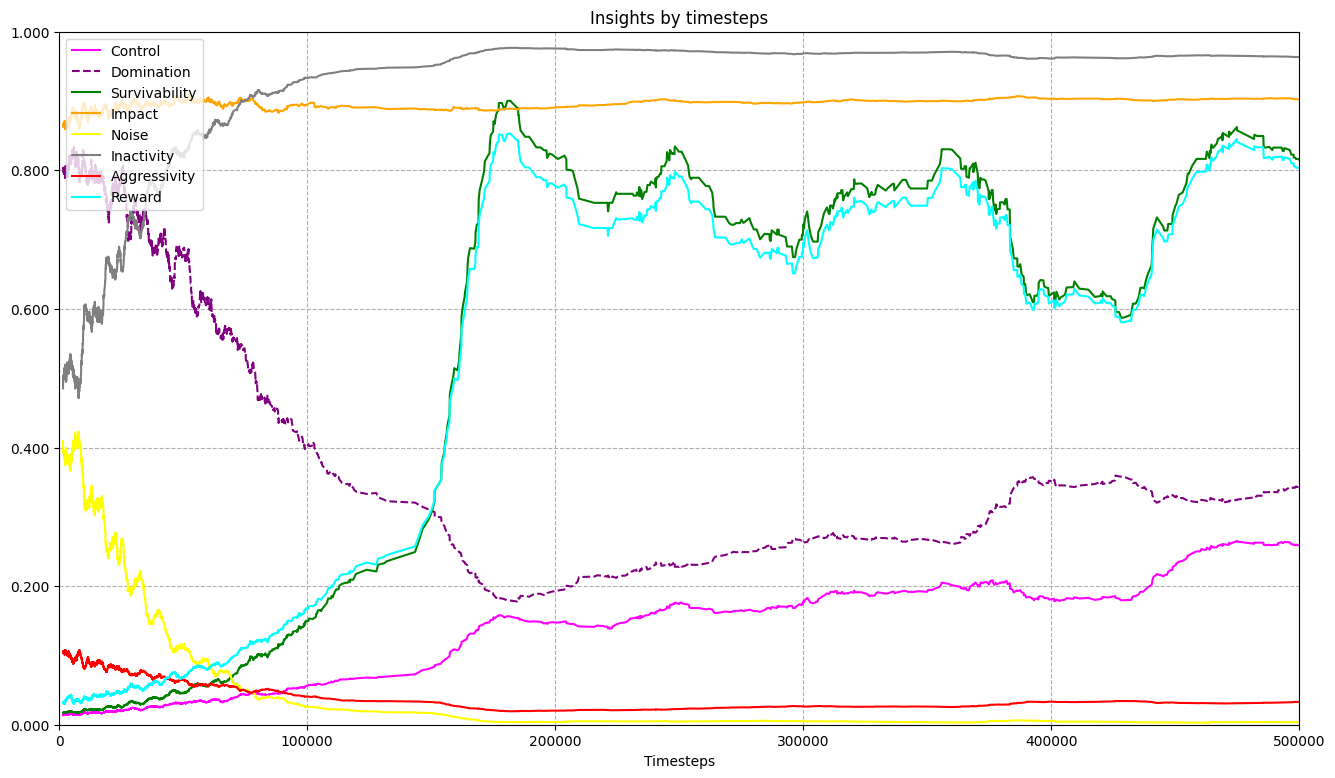

In [ ]:
# Create train environnement
train_env = VecMonitor(
    MonitorVecInsights(
        CanBusVecEnv(
            model=recccn,
            dataset=train_dataset,
            **parameters["env"],
        )
    ),
    filename=str(STORAGE / "monitor.csv"),
    **parameters["monitor"],
)

# Convert str activations function to a tensorflow function
policy_kwargs = parameters["model"]["policy_kwargs"].copy()
policy_kwargs["activation_fn"] = activations[policy_kwargs["activation_fn"]]
model_parameters = {
    **parameters["model"],
    "policy_kwargs": policy_kwargs,
}

# Create Model on the train env
model = PPO(
    "MlpPolicy",
    train_env,
    **model_parameters,
    verbose=1,
    seed=SEED + 1,
    stats_window_size=64,
)

# Train the model
close_all_tqdm()
model.learn(
    total_timesteps=parameters["train"]["total_timesteps"],
    log_interval=None,
    progress_bar=True,
)

# Flush monitor file
train_env.close()

# Save Model
(STORAGE / "encoder-DQN.pickle").write_bytes(
    pickle.dumps(train_env.dataset.encoder)
)
(STORAGE / "parameters-DQN.json").write_text(json.dumps(parameters))
model.save(STORAGE / "DQN")

## Train Analysis

### Load statistics

In [ ]:
df = pd.read_csv((STORAGE / "monitor.csv"), delimiter=",", skiprows=1)

### Ratio by timesteps

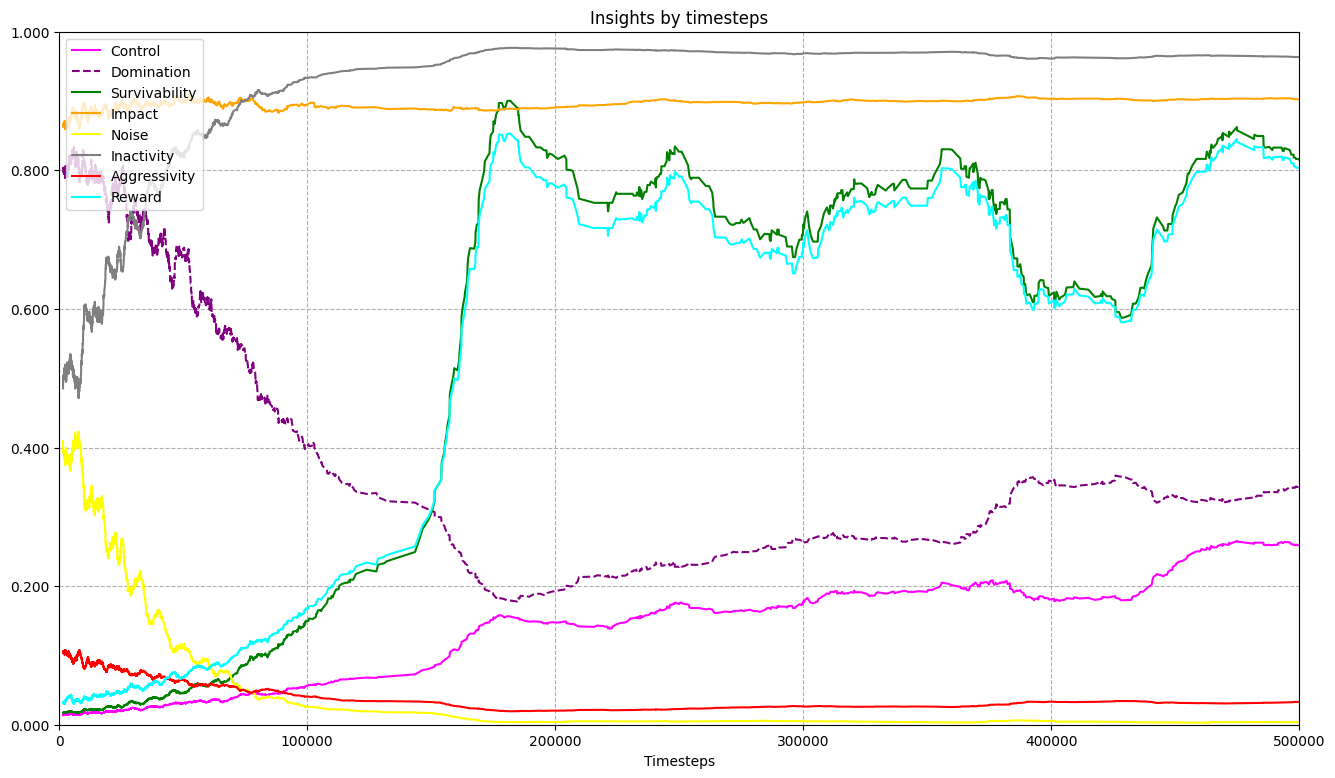

In [ ]:
ins = Insights()
ins.plot(df)
ins.close()

### Reward over timesteps

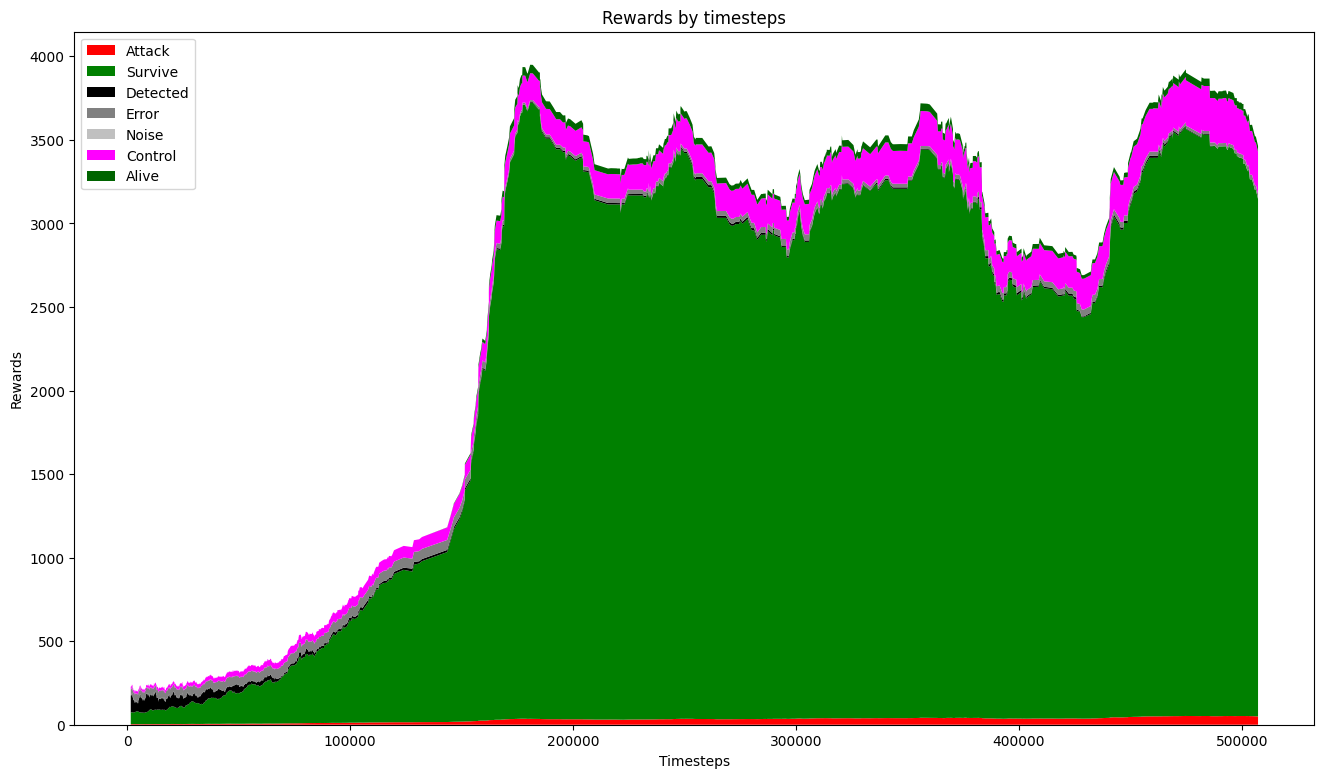

In [ ]:
plt.figure(figsize=(16, 9))
x = df["num_timesteps"]
y = np.vstack(
    [
        rolling(df["attack_reward"]),
        rolling(df["survive_reward"]),
        rolling(-df["detected_reward"]),
        rolling(-df["error_reward"]),
        rolling(-df["noise_reward"]),
        rolling(df["control_reward"]),
        rolling(df["alive_reward"]),
    ]
)
plt.xlabel("Timesteps")
plt.ylabel("Rewards")
add_exploration_line(parameters)

# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.stackplot(
    x,
    y,
    labels=[
        "Attack",
        "Survive",
        "Detected",
        "Error",
        "Noise",
        "Control",
        "Alive",
    ],
    colors=["red", "green", "black", "grey", "silver", "fuchsia", "darkgreen"],
)
plt.legend()
plt.title("Rewards by timesteps")
plt.show()

### Step repartion by timestemps

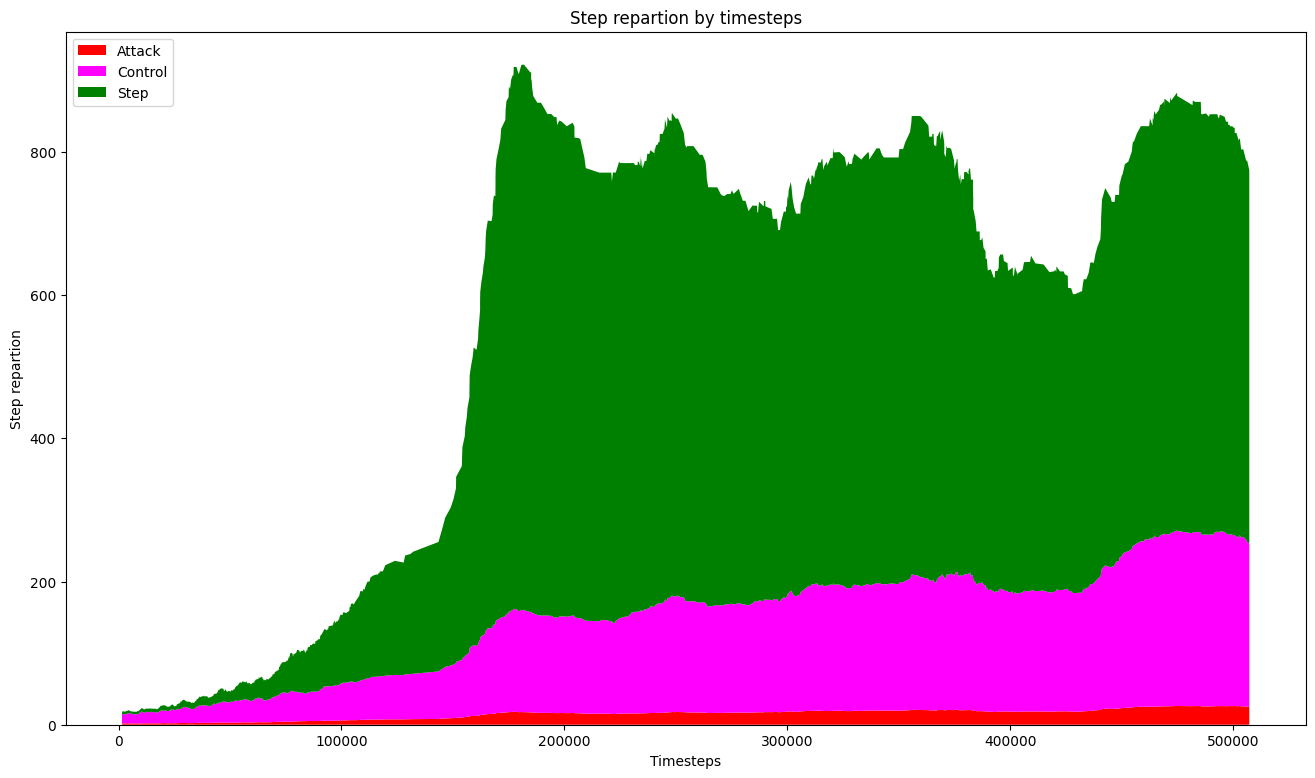

In [ ]:
plt.figure(figsize=(16, 9))
x = df["num_timesteps"]
y = np.vstack(
    [
        rolling(df["attack_count"]),
        rolling(df["control_count"] - df["attack_count"]),
        rolling(df["step"] - df["control_count"]),
    ]
)
plt.xlabel("Timesteps")
plt.ylabel("Step repartion")
add_exploration_line(parameters)
plt.stackplot(
    x,
    y,
    labels=["Attack", "Control", "Step"],
    colors=["red", "fuchsia", "green"],
)
plt.legend()
plt.title("Step repartion by timesteps")
plt.show()

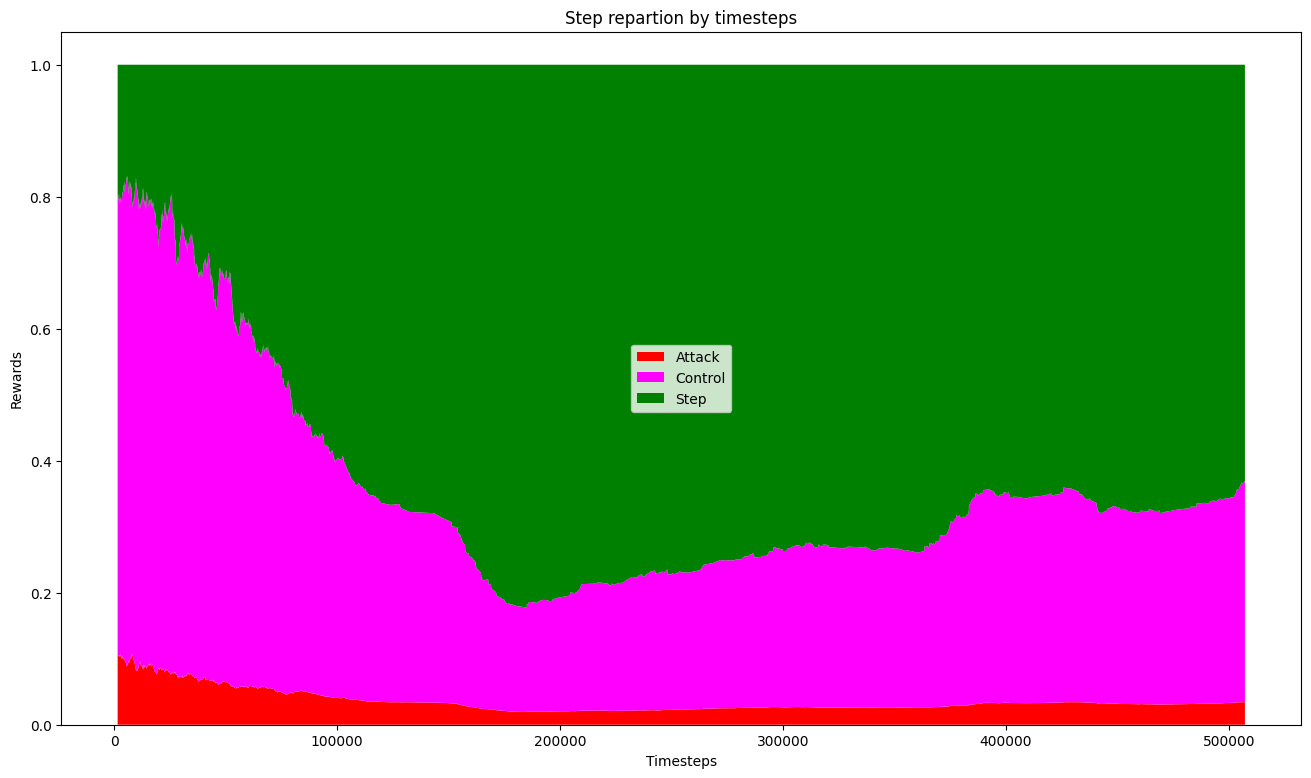

In [ ]:
plt.figure(figsize=(16, 9))
x = df["num_timesteps"]
a = df["attack_count"] / df["step"]
c = (df["control_count"] - df["attack_count"]) / df["step"]
s = (df["step"] - df["control_count"]) / df["step"]
y = np.vstack([rolling(a), rolling(c), rolling(s)])
plt.xlabel("Timesteps")
plt.ylabel("Rewards")
add_exploration_line(parameters)
plt.stackplot(
    x,
    y,
    labels=["Attack", "Control", "Step"],
    colors=["red", "fuchsia", "green"],
)
plt.legend()
plt.title("Step repartion by timesteps")
plt.show()

### Impact

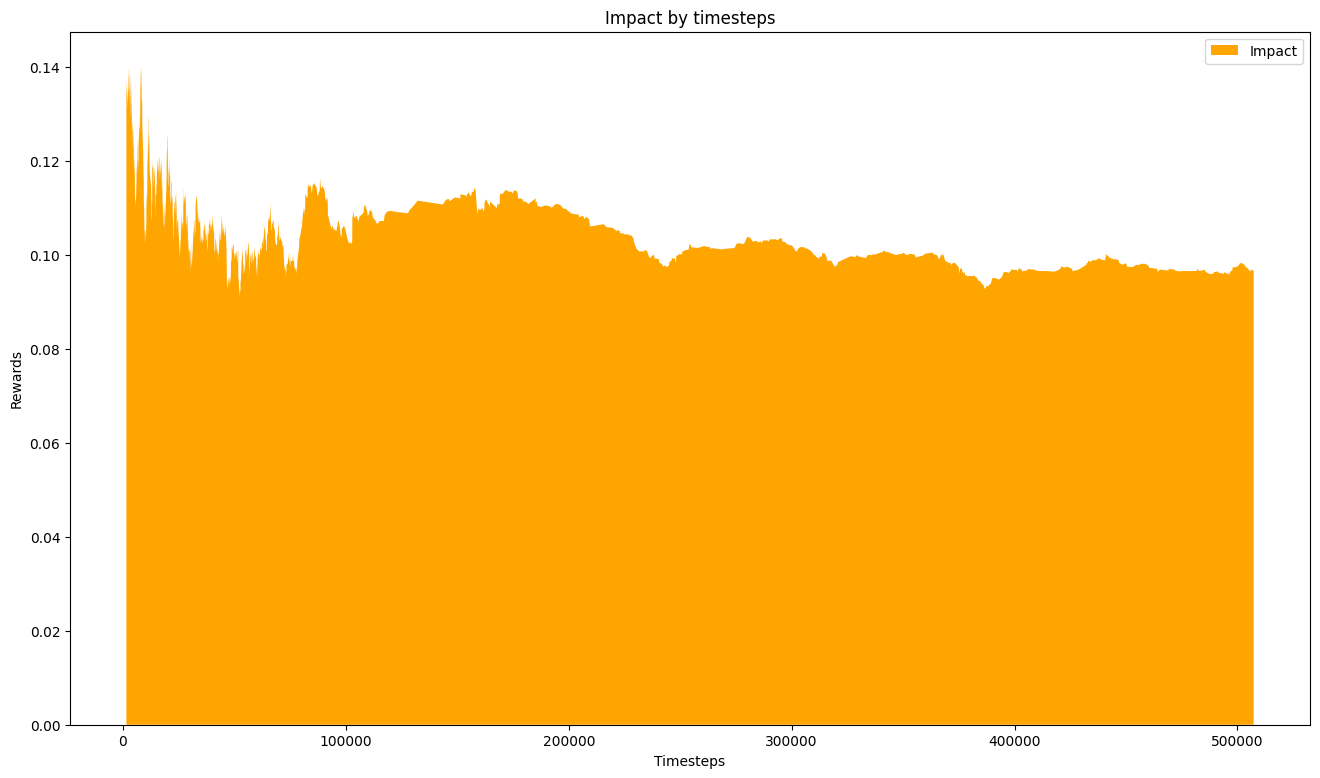

In [ ]:
plt.figure(figsize=(16, 9))
x = df["num_timesteps"]
y = rolling(df["attack_count"].divide(df["control_count"]).fillna(0))
plt.xlabel("Timesteps")
plt.ylabel("Rewards")
add_exploration_line(parameters)
plt.stackplot(x, y, labels=["Impact"], colors=["orange"])
plt.legend()
plt.title("Impact by timesteps")
plt.show()

### Episode over timestemps

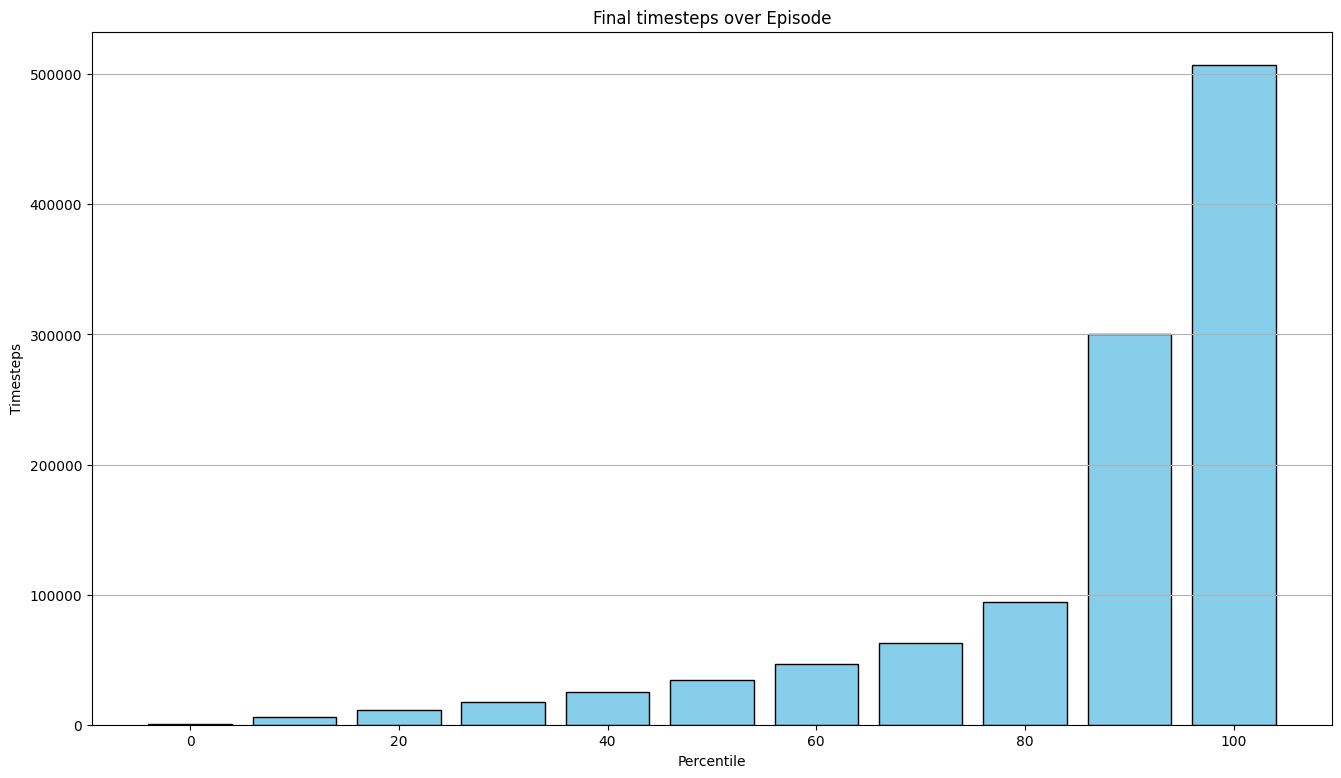

In [ ]:
# Example data for X
X = df["num_timesteps"]

# Define the desired percentiles (0% to 100% in steps of 5)
percents = np.arange(0, 101, 10)
percentile_values = np.percentile(X, percents)

# Create a bar plot for the percentiles
plt.figure(figsize=(16, 9))
plt.bar(
    percents, percentile_values, width=8, color="skyblue", edgecolor="black"
)
plt.xlabel("Percentile")
plt.ylabel("Timesteps")
plt.title("Final timesteps over Episode")
plt.grid(visible=True, axis="y")
plt.show()

## Test

### Test function

In [ ]:
def test_model(  # noqa: PLR0913
    model: AbstractModel,
    recccn: RecCNN,
    dataset: Dataset,
    parameters: dict[str, Any],
    episode_per_env: int = 1,
    n_envs: int = 64,
    *,
    progress_bar: bool = False,
    deterministic: bool = True,
):
    """Test the current model."""
    # Create env test
    env_parameters = parameters["env"].copy()
    env_parameters["n_envs"] = n_envs
    test_env = CanBusVecEnv(
        **env_parameters,
        model=recccn,
        dataset=dataset,
    )

    # Create progress bar
    max_step = parameters["env"]["max_timesteps"] * episode_per_env * n_envs
    episodes = 0
    max_episodes = episode_per_env * n_envs
    close_all_tqdm()
    with tqdm_rich(
        desc=f"Episodes (0/{max_episodes})",
        total=max_step,
        disable=not progress_bar,
    ) as t:
        # Initialise env
        observations = test_env.reset()
        all_infos = []
        arr_episodes = [0 for i in range(n_envs)]

        # Stop the simulation once the episodes reach
        while any(episodes < episode_per_env for episodes in arr_episodes):
            # Run a step env
            actions, states = model.predict(
                observations,
                deterministic=deterministic,
            )
            observations, rewards, dones, infos = test_env.step(actions)

            # Update progress bar and update env count
            for i, (*_, done, info) in enumerate(
                zip(observations, rewards, dones, infos)
            ):
                if done and arr_episodes[i] < episode_per_env:
                    all_infos.append(info)
                    arr_episodes[i] += 1
                    episodes += 1
                    t.set_description(f"Episodes ({episodes}/{max_episodes})")
            t.update(n_envs)
            t.display()
            if hasattr(t, "_prog"):
                t._prog.live.refresh()  # noqa: SLF001
    test_env.close()
    df = pd.DataFrame(all_infos)
    df = compute_insights(df)
    return df.mean()

### Test model

In [ ]:
parameters = json.loads((STORAGE / "parameters-DQN.json").read_text())
model = PPO.load(STORAGE / "DQN")
recccn = RecCNN(
    model_path=STORAGE / "Rec-CNN.keras",
    encoder_path=STORAGE / "encoder-Rec-CNN.pickle",
)
test_dataset = Dataset.load_test(
    STORAGE / "benign.parquet.br",
    STORAGE / "encoder-DQN.pickle",
    test_size=parameters["data"]["test_size"],
)
df_test = test_model(
    model=model,
    recccn=recccn,
    dataset=test_dataset,
    parameters=parameters,
    progress_bar=True,
    deterministic=False,
)

Output()

### Show result

In [ ]:
final_score = score(df_test)
print(
    f"{df_test['attack_count']:.2f} attacks "
    f"/ {df_test['control_count']:.2f} controls "
    f"/ {df_test['step']:.0f} steps "
    f"/ {df_test['max_timesteps']:.0f} max, "
    f"noise: {df_test['noise']:.1f}, "
    f"impact: {df_test['impact_count']:.1f}, "
    f"domination: {df_test['control_count']/df_test['step']:.0%}, "
    f"survivability: {df_test['step']/df_test['max_timesteps']:.0%}, "
    f"score: {final_score:.4f}"
)

28.50 attacks / 289.56 controls / 852 steps / 1024 max, noise: 0.0, impact: 10.2, domination: 34%, survivability: 83%, score: 0.7884


## Random Compute

### Random Model

In [ ]:
class RandomModel(AbstractModel):
    def __init__(
        self, attack_probability: float, *, seed: Optional[int] = None
    ) -> None:
        """Instantiate random model."""
        self.attack_probability = attack_probability
        self.generator = np.random.Generator(np.random.PCG64(seed))

    def predict(
        self,
        observation: Union[np.ndarray, dict[str, np.ndarray]],
        state: Optional[tuple[np.ndarray, ...]] = None,  # noqa: ARG002
        episode_start: Optional[np.ndarray] = None,  # noqa: ARG002
        deterministic: bool = False,  # noqa: ARG002, FBT001, FBT002
    ) -> tuple[np.ndarray, Optional[tuple[np.ndarray, ...]]]:
        """Get a random prediction."""
        actions = self.generator.choice(
            [0, 1],
            len(observation),
            p=[1 - self.attack_probability, self.attack_probability],
        )
        return actions, {}

### Run simulation

In [ ]:
N = 201
train_dataset = Dataset.load_test(
    STORAGE / "benign.parquet.br",
    STORAGE / "encoder-DQN.pickle",
    test_size=parameters["data"]["test_size"],
)
space = list(map(float, np.linspace(0, 1, N, dtype=np.float64)))
recccn = RecCNN(
    model_path=STORAGE / "Rec-CNN.keras",
    encoder_path=STORAGE / "encoder-Rec-CNN.pickle",
)
i = []
arr_random = []
print(f"Test with probabilities: {space}")
close_all_tqdm()
for i, prob in enumerate(tqdm_auto(space, desc="Probability")):
    print(f"Start {i + 1}/{N} with attack probability of {prob:.4f}")
    df_info = test_model(
        model=RandomModel(prob),
        dataset=train_dataset,
        recccn=recccn,
        parameters=parameters,
        progress_bar=True,
        n_envs=64,
        episode_per_env=2,
    )
    df_info["attack_probability"] = prob
    print(f"Domination: {df_info['domination']:.02%}")
    print(f"Survivability: {df_info['survivability']:.02%}")
    print()
    arr_random.append(df_info)
df_random = pd.DataFrame(arr_random)
df_random.to_csv(STORAGE / "random.csv")

Test with probabilities: [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0.195, 0.2, 0.20500000000000002, 0.21, 0.215, 0.22, 0.225, 0.23, 0.23500000000000001, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.28500000000000003, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.34500000000000003, 0.35000000000000003, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41000000000000003, 0.41500000000000004, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47000000000000003, 0.47500000000000003, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.5650000000000001, 0.5700000000000001, 0.5750000000000001, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61,

Probability:   0%|          | 0/201 [00:00<?, ?it/s]

Start 1/201 with attack probability of 0.0000


Output()

Domination: 0.00%
Survivability: 100.00%

Start 2/201 with attack probability of 0.0050


Output()

Domination: 5.10%
Survivability: 100.00%

Start 3/201 with attack probability of 0.0100


Output()

Domination: 9.61%
Survivability: 99.24%

Start 4/201 with attack probability of 0.0150


Output()

Domination: 13.85%
Survivability: 91.39%

Start 5/201 with attack probability of 0.0200


Output()

Domination: 17.66%
Survivability: 88.89%

Start 6/201 with attack probability of 0.0250


Output()

Domination: 23.15%
Survivability: 67.68%

Start 7/201 with attack probability of 0.0300


Output()

Domination: 25.33%
Survivability: 64.52%

Start 8/201 with attack probability of 0.0350


Output()

Domination: 29.39%
Survivability: 48.79%

Start 9/201 with attack probability of 0.0400


Output()

Domination: 33.10%
Survivability: 40.74%

Start 10/201 with attack probability of 0.0450


Output()

Domination: 36.11%
Survivability: 31.43%

Start 11/201 with attack probability of 0.0500


Output()

Domination: 39.04%
Survivability: 22.79%

Start 12/201 with attack probability of 0.0550


Output()

Domination: 42.33%
Survivability: 19.89%

Start 13/201 with attack probability of 0.0600


Output()

Domination: 43.81%
Survivability: 15.50%

Start 14/201 with attack probability of 0.0650


Output()

Domination: 45.50%
Survivability: 14.28%

Start 15/201 with attack probability of 0.0700


Output()

Domination: 48.15%
Survivability: 12.08%

Start 16/201 with attack probability of 0.0750


Output()

Domination: 51.40%
Survivability: 11.83%

Start 17/201 with attack probability of 0.0800


Output()

Domination: 53.02%
Survivability: 10.51%

Start 18/201 with attack probability of 0.0850


Output()

Domination: 51.78%
Survivability: 9.81%

Start 19/201 with attack probability of 0.0900


Output()

Domination: 54.12%
Survivability: 8.90%

Start 20/201 with attack probability of 0.0950


Output()

Domination: 58.69%
Survivability: 7.95%

Start 21/201 with attack probability of 0.1000


Output()

Domination: 58.07%
Survivability: 8.07%

Start 22/201 with attack probability of 0.1050


Output()

Domination: 59.80%
Survivability: 7.46%

Start 23/201 with attack probability of 0.1100


Output()

Domination: 59.46%
Survivability: 7.59%

Start 24/201 with attack probability of 0.1150


Output()

Domination: 61.54%
Survivability: 6.65%

Start 25/201 with attack probability of 0.1200


Output()

Domination: 64.10%
Survivability: 6.52%

Start 26/201 with attack probability of 0.1250


Output()

Domination: 63.69%
Survivability: 5.88%

Start 27/201 with attack probability of 0.1300


Output()

Domination: 63.48%
Survivability: 6.10%

Start 28/201 with attack probability of 0.1350


Output()

Domination: 66.01%
Survivability: 5.57%

Start 29/201 with attack probability of 0.1400


Output()

Domination: 66.32%
Survivability: 5.86%

Start 30/201 with attack probability of 0.1450


Output()

Domination: 64.61%
Survivability: 5.46%

Start 31/201 with attack probability of 0.1500


Output()

Domination: 67.91%
Survivability: 5.12%

Start 32/201 with attack probability of 0.1550


Output()

Domination: 68.09%
Survivability: 5.08%

Start 33/201 with attack probability of 0.1600


Output()

Domination: 70.15%
Survivability: 4.86%

Start 34/201 with attack probability of 0.1650


Output()

Domination: 71.28%
Survivability: 4.58%

Start 35/201 with attack probability of 0.1700


Output()

Domination: 73.03%
Survivability: 4.52%

Start 36/201 with attack probability of 0.1750


Output()

Domination: 71.03%
Survivability: 4.52%

Start 37/201 with attack probability of 0.1800


Output()

Domination: 71.43%
Survivability: 4.37%

Start 38/201 with attack probability of 0.1850


Output()

Domination: 69.61%
Survivability: 4.31%

Start 39/201 with attack probability of 0.1900


Output()

Domination: 73.12%
Survivability: 4.14%

Start 40/201 with attack probability of 0.1950


Output()

Domination: 73.63%
Survivability: 4.24%

Start 41/201 with attack probability of 0.2000


Output()

Domination: 74.58%
Survivability: 4.04%

Start 42/201 with attack probability of 0.2050


Output()

Domination: 72.57%
Survivability: 3.96%

Start 43/201 with attack probability of 0.2100


Output()

Domination: 73.23%
Survivability: 4.02%

Start 44/201 with attack probability of 0.2150


Output()

Domination: 73.96%
Survivability: 3.71%

Start 45/201 with attack probability of 0.2200


Output()

Domination: 76.09%
Survivability: 3.76%

Start 46/201 with attack probability of 0.2250


Output()

Domination: 76.00%
Survivability: 3.56%

Start 47/201 with attack probability of 0.2300


Output()

Domination: 74.11%
Survivability: 3.42%

Start 48/201 with attack probability of 0.2350


Output()

Domination: 74.74%
Survivability: 3.60%

Start 49/201 with attack probability of 0.2400


Output()

Domination: 75.41%
Survivability: 3.36%

Start 50/201 with attack probability of 0.2450


Output()

Domination: 78.17%
Survivability: 3.21%

Start 51/201 with attack probability of 0.2500


Output()

Domination: 78.84%
Survivability: 3.25%

Start 52/201 with attack probability of 0.2550


Output()

Domination: 78.44%
Survivability: 3.19%

Start 53/201 with attack probability of 0.2600


Output()

Domination: 77.31%
Survivability: 3.18%

Start 54/201 with attack probability of 0.2650


Output()

Domination: 76.64%
Survivability: 3.22%

Start 55/201 with attack probability of 0.2700


Output()

Domination: 76.71%
Survivability: 3.10%

Start 56/201 with attack probability of 0.2750


Output()

Domination: 78.30%
Survivability: 3.07%

Start 57/201 with attack probability of 0.2800


Output()

Domination: 75.43%
Survivability: 3.04%

Start 58/201 with attack probability of 0.2850


Output()

Domination: 79.18%
Survivability: 3.06%

Start 59/201 with attack probability of 0.2900


Output()

Domination: 78.60%
Survivability: 3.02%

Start 60/201 with attack probability of 0.2950


Output()

Domination: 79.84%
Survivability: 2.79%

Start 61/201 with attack probability of 0.3000


Output()

Domination: 79.54%
Survivability: 2.79%

Start 62/201 with attack probability of 0.3050


Output()

Domination: 80.36%
Survivability: 2.88%

Start 63/201 with attack probability of 0.3100


Output()

Domination: 79.71%
Survivability: 2.73%

Start 64/201 with attack probability of 0.3150


Output()

Domination: 79.36%
Survivability: 2.68%

Start 65/201 with attack probability of 0.3200


Output()

Domination: 79.91%
Survivability: 2.68%

Start 66/201 with attack probability of 0.3250


Output()

Domination: 80.70%
Survivability: 2.57%

Start 67/201 with attack probability of 0.3300


Output()

Domination: 79.41%
Survivability: 2.57%

Start 68/201 with attack probability of 0.3350


Output()

Domination: 81.06%
Survivability: 2.55%

Start 69/201 with attack probability of 0.3400


Output()

Domination: 80.93%
Survivability: 2.41%

Start 70/201 with attack probability of 0.3450


Output()

Domination: 80.88%
Survivability: 2.58%

Start 71/201 with attack probability of 0.3500


Output()

Domination: 80.13%
Survivability: 2.42%

Start 72/201 with attack probability of 0.3550


Output()

Domination: 82.71%
Survivability: 2.48%

Start 73/201 with attack probability of 0.3600


Output()

Domination: 80.18%
Survivability: 2.43%

Start 74/201 with attack probability of 0.3650


Output()

Domination: 83.40%
Survivability: 2.41%

Start 75/201 with attack probability of 0.3700


Output()

Domination: 82.01%
Survivability: 2.33%

Start 76/201 with attack probability of 0.3750


Output()

Domination: 80.92%
Survivability: 2.34%

Start 77/201 with attack probability of 0.3800


Output()

Domination: 82.40%
Survivability: 2.35%

Start 78/201 with attack probability of 0.3850


Output()

Domination: 81.43%
Survivability: 2.28%

Start 79/201 with attack probability of 0.3900


Output()

Domination: 81.68%
Survivability: 2.27%

Start 80/201 with attack probability of 0.3950


Output()

Domination: 82.79%
Survivability: 2.16%

Start 81/201 with attack probability of 0.4000


Output()

Domination: 83.00%
Survivability: 2.27%

Start 82/201 with attack probability of 0.4050


Output()

Domination: 83.55%
Survivability: 2.20%

Start 83/201 with attack probability of 0.4100


Output()

Domination: 82.51%
Survivability: 2.24%

Start 84/201 with attack probability of 0.4150


Output()

Domination: 82.82%
Survivability: 2.06%

Start 85/201 with attack probability of 0.4200


Output()

Domination: 82.99%
Survivability: 2.13%

Start 86/201 with attack probability of 0.4250


Output()

Domination: 84.13%
Survivability: 2.11%

Start 87/201 with attack probability of 0.4300


Output()

Domination: 82.60%
Survivability: 2.07%

Start 88/201 with attack probability of 0.4350


Output()

Domination: 83.90%
Survivability: 2.04%

Start 89/201 with attack probability of 0.4400


Output()

Domination: 85.02%
Survivability: 2.06%

Start 90/201 with attack probability of 0.4450


Output()

Domination: 84.31%
Survivability: 1.99%

Start 91/201 with attack probability of 0.4500


Output()

Domination: 85.03%
Survivability: 2.03%

Start 92/201 with attack probability of 0.4550


Output()

Domination: 86.43%
Survivability: 1.91%

Start 93/201 with attack probability of 0.4600


Output()

Domination: 84.56%
Survivability: 1.96%

Start 94/201 with attack probability of 0.4650


Output()

Domination: 87.05%
Survivability: 1.89%

Start 95/201 with attack probability of 0.4700


Output()

Domination: 84.49%
Survivability: 1.90%

Start 96/201 with attack probability of 0.4750


Output()

Domination: 85.79%
Survivability: 1.84%

Start 97/201 with attack probability of 0.4800


Output()

Domination: 84.08%
Survivability: 1.85%

Start 98/201 with attack probability of 0.4850


Output()

Domination: 84.51%
Survivability: 1.88%

Start 99/201 with attack probability of 0.4900


Output()

Domination: 86.07%
Survivability: 1.85%

Start 100/201 with attack probability of 0.4950


Output()

Domination: 86.45%
Survivability: 1.82%

Start 101/201 with attack probability of 0.5000


Output()

Domination: 85.57%
Survivability: 1.83%

Start 102/201 with attack probability of 0.5050


Output()

Domination: 86.01%
Survivability: 1.79%

Start 103/201 with attack probability of 0.5100


Output()

Domination: 85.81%
Survivability: 1.79%

Start 104/201 with attack probability of 0.5150


Output()

Domination: 84.90%
Survivability: 1.75%

Start 105/201 with attack probability of 0.5200


Output()

Domination: 85.08%
Survivability: 1.74%

Start 106/201 with attack probability of 0.5250


Output()

Domination: 84.59%
Survivability: 1.78%

Start 107/201 with attack probability of 0.5300


Output()

Domination: 85.77%
Survivability: 1.75%

Start 108/201 with attack probability of 0.5350


Output()

Domination: 86.45%
Survivability: 1.66%

Start 109/201 with attack probability of 0.5400


Output()

Domination: 85.17%
Survivability: 1.73%

Start 110/201 with attack probability of 0.5450


Output()

Domination: 86.72%
Survivability: 1.70%

Start 111/201 with attack probability of 0.5500


Output()

Domination: 87.03%
Survivability: 1.66%

Start 112/201 with attack probability of 0.5550


Output()

Domination: 86.89%
Survivability: 1.69%

Start 113/201 with attack probability of 0.5600


Output()

Domination: 86.29%
Survivability: 1.73%

Start 114/201 with attack probability of 0.5650


Output()

Domination: 85.62%
Survivability: 1.63%

Start 115/201 with attack probability of 0.5700


Output()

Domination: 87.17%
Survivability: 1.56%

Start 116/201 with attack probability of 0.5750


Output()

Domination: 85.87%
Survivability: 1.61%

Start 117/201 with attack probability of 0.5800


Output()

Domination: 86.85%
Survivability: 1.62%

Start 118/201 with attack probability of 0.5850


Output()

Domination: 87.16%
Survivability: 1.63%

Start 119/201 with attack probability of 0.5900


Output()

Domination: 86.14%
Survivability: 1.58%

Start 120/201 with attack probability of 0.5950


Output()

Domination: 86.30%
Survivability: 1.58%

Start 121/201 with attack probability of 0.6000


Output()

Domination: 86.55%
Survivability: 1.54%

Start 122/201 with attack probability of 0.6050


Output()

Domination: 86.61%
Survivability: 1.53%

Start 123/201 with attack probability of 0.6100


Output()

Domination: 87.88%
Survivability: 1.59%

Start 124/201 with attack probability of 0.6150


Output()

Domination: 87.81%
Survivability: 1.53%

Start 125/201 with attack probability of 0.6200


Output()

Domination: 87.83%
Survivability: 1.51%

Start 126/201 with attack probability of 0.6250


Output()

Domination: 86.79%
Survivability: 1.57%

Start 127/201 with attack probability of 0.6300


Output()

Domination: 86.61%
Survivability: 1.51%

Start 128/201 with attack probability of 0.6350


Output()

Domination: 87.37%
Survivability: 1.47%

Start 129/201 with attack probability of 0.6400


Output()

Domination: 87.97%
Survivability: 1.51%

Start 130/201 with attack probability of 0.6450


Output()

Domination: 87.24%
Survivability: 1.49%

Start 131/201 with attack probability of 0.6500


Output()

Domination: 88.74%
Survivability: 1.49%

Start 132/201 with attack probability of 0.6550


Output()

Domination: 87.15%
Survivability: 1.48%

Start 133/201 with attack probability of 0.6600


Output()

Domination: 87.70%
Survivability: 1.48%

Start 134/201 with attack probability of 0.6650


Output()

Domination: 88.38%
Survivability: 1.46%

Start 135/201 with attack probability of 0.6700


Output()

Domination: 88.56%
Survivability: 1.40%

Start 136/201 with attack probability of 0.6750


Output()

Domination: 88.94%
Survivability: 1.47%

Start 137/201 with attack probability of 0.6800


Output()

Domination: 88.84%
Survivability: 1.38%

Start 138/201 with attack probability of 0.6850


Output()

Domination: 89.38%
Survivability: 1.38%

Start 139/201 with attack probability of 0.6900


Output()

Domination: 89.29%
Survivability: 1.40%

Start 140/201 with attack probability of 0.6950


Output()

Domination: 88.06%
Survivability: 1.38%

Start 141/201 with attack probability of 0.7000


Output()

Domination: 88.58%
Survivability: 1.38%

Start 142/201 with attack probability of 0.7050


Output()

Domination: 87.94%
Survivability: 1.37%

Start 143/201 with attack probability of 0.7100


Output()

Domination: 89.62%
Survivability: 1.42%

Start 144/201 with attack probability of 0.7150


Output()

Domination: 87.27%
Survivability: 1.38%

Start 145/201 with attack probability of 0.7200


Output()

Domination: 88.17%
Survivability: 1.34%

Start 146/201 with attack probability of 0.7250


Output()

Domination: 88.09%
Survivability: 1.36%

Start 147/201 with attack probability of 0.7300


Output()

Domination: 88.90%
Survivability: 1.35%

Start 148/201 with attack probability of 0.7350


Output()

Domination: 89.11%
Survivability: 1.35%

Start 149/201 with attack probability of 0.7400


Output()

Domination: 87.82%
Survivability: 1.30%

Start 150/201 with attack probability of 0.7450


Output()

Domination: 88.73%
Survivability: 1.34%

Start 151/201 with attack probability of 0.7500


Output()

Domination: 88.04%
Survivability: 1.31%

Start 152/201 with attack probability of 0.7550


Output()

Domination: 88.97%
Survivability: 1.32%

Start 153/201 with attack probability of 0.7600


Output()

Domination: 88.47%
Survivability: 1.28%

Start 154/201 with attack probability of 0.7650


Output()

Domination: 89.34%
Survivability: 1.32%

Start 155/201 with attack probability of 0.7700


Output()

Domination: 89.04%
Survivability: 1.31%

Start 156/201 with attack probability of 0.7750


Output()

Domination: 88.64%
Survivability: 1.29%

Start 157/201 with attack probability of 0.7800


Output()

Domination: 89.59%
Survivability: 1.27%

Start 158/201 with attack probability of 0.7850


Output()

Domination: 89.00%
Survivability: 1.26%

Start 159/201 with attack probability of 0.7900


Output()

Domination: 89.67%
Survivability: 1.26%

Start 160/201 with attack probability of 0.7950


Output()

Domination: 89.78%
Survivability: 1.26%

Start 161/201 with attack probability of 0.8000


Output()

Domination: 88.90%
Survivability: 1.23%

Start 162/201 with attack probability of 0.8050


Output()

Domination: 89.90%
Survivability: 1.24%

Start 163/201 with attack probability of 0.8100


Output()

Domination: 89.85%
Survivability: 1.26%

Start 164/201 with attack probability of 0.8150


Output()

Domination: 89.61%
Survivability: 1.23%

Start 165/201 with attack probability of 0.8200


Output()

Domination: 89.35%
Survivability: 1.21%

Start 166/201 with attack probability of 0.8250


Output()

Domination: 89.16%
Survivability: 1.23%

Start 167/201 with attack probability of 0.8300


Output()

Domination: 89.45%
Survivability: 1.22%

Start 168/201 with attack probability of 0.8350


Output()

Domination: 90.13%
Survivability: 1.19%

Start 169/201 with attack probability of 0.8400


Output()

Domination: 89.34%
Survivability: 1.22%

Start 170/201 with attack probability of 0.8450


Output()

Domination: 89.51%
Survivability: 1.19%

Start 171/201 with attack probability of 0.8500


Output()

Domination: 89.55%
Survivability: 1.22%

Start 172/201 with attack probability of 0.8550


Output()

Domination: 89.34%
Survivability: 1.18%

Start 173/201 with attack probability of 0.8600


Output()

Domination: 89.38%
Survivability: 1.20%

Start 174/201 with attack probability of 0.8650


Output()

Domination: 89.43%
Survivability: 1.18%

Start 175/201 with attack probability of 0.8700


Output()

Domination: 89.40%
Survivability: 1.18%

Start 176/201 with attack probability of 0.8750


Output()

Domination: 89.65%
Survivability: 1.17%

Start 177/201 with attack probability of 0.8800


Output()

Domination: 89.84%
Survivability: 1.17%

Start 178/201 with attack probability of 0.8850


Output()

Domination: 89.97%
Survivability: 1.17%

Start 179/201 with attack probability of 0.8900


Output()

Domination: 89.69%
Survivability: 1.15%

Start 180/201 with attack probability of 0.8950


Output()

Domination: 90.22%
Survivability: 1.14%

Start 181/201 with attack probability of 0.9000


Output()

Domination: 90.06%
Survivability: 1.12%

Start 182/201 with attack probability of 0.9050


Output()

Domination: 89.85%
Survivability: 1.14%

Start 183/201 with attack probability of 0.9100


Output()

Domination: 89.74%
Survivability: 1.13%

Start 184/201 with attack probability of 0.9150


Output()

Domination: 90.21%
Survivability: 1.13%

Start 185/201 with attack probability of 0.9200


Output()

Domination: 89.63%
Survivability: 1.12%

Start 186/201 with attack probability of 0.9250


Output()

Domination: 90.14%
Survivability: 1.12%

Start 187/201 with attack probability of 0.9300


Output()

Domination: 90.16%
Survivability: 1.11%

Start 188/201 with attack probability of 0.9350


Output()

Domination: 90.17%
Survivability: 1.11%

Start 189/201 with attack probability of 0.9400


Output()

Domination: 90.65%
Survivability: 1.12%

Start 190/201 with attack probability of 0.9450


Output()

Domination: 90.24%
Survivability: 1.09%

Start 191/201 with attack probability of 0.9500


Output()

Domination: 90.56%
Survivability: 1.13%

Start 192/201 with attack probability of 0.9550


Output()

Domination: 90.25%
Survivability: 1.10%

Start 193/201 with attack probability of 0.9600


Output()

Domination: 90.34%
Survivability: 1.08%

Start 194/201 with attack probability of 0.9650


Output()

Domination: 90.14%
Survivability: 1.07%

Start 195/201 with attack probability of 0.9700


Output()

Domination: 90.43%
Survivability: 1.08%

Start 196/201 with attack probability of 0.9750


Output()

Domination: 90.40%
Survivability: 1.09%

Start 197/201 with attack probability of 0.9800


Output()

Domination: 90.49%
Survivability: 1.07%

Start 198/201 with attack probability of 0.9850


Output()

Domination: 90.39%
Survivability: 1.06%

Start 199/201 with attack probability of 0.9900


Output()

Domination: 90.56%
Survivability: 1.06%

Start 200/201 with attack probability of 0.9950


Output()

Domination: 90.56%
Survivability: 1.06%

Start 201/201 with attack probability of 1.0000


Output()

Domination: 90.40%
Survivability: 1.03%



### Store result

In [ ]:
df_random = pd.DataFrame(arr_random)
df_random.to_csv(STORAGE / "random.csv")

## Random Analysis

### Load statistics

In [ ]:
df_random = pd.read_csv(STORAGE / "random.csv")
display(df_random.shape)
display(df_random.columns)

(201, 50)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'control_duration',
       'duration', 'done', 'alive', 'detected', 'error_attack', 'error_idle',
       'attack_count', 'noise_count', 'control_count', 'step', 'max_timesteps',
       'max_duration', 'num_timesteps', 'r', 'attack_reward', 'survive_reward',
       'detected_reward', 'error_reward', 'control_reward', 'alive_reward',
       'noise_reward', 'false_positive_count', 'true_positive_count',
       'false_negative_count', 'true_negative_count', 'control', 'domination',
       'survivability', 'impact', 'aggressivity', 'noise', 'inactivity',
       'score', 'reward_ratio', 'attack_reward_ratio', 'survive_reward_ratio',
       'detected_reward_ratio', 'control_reward_ratio', 'alive_reward_ratio',
       'false_count', 'true_count', 'FPR', 'TNR', 'FNR', 'TPR',
       'attack_probability'],
      dtype='object')

### Resolve parameters

In [ ]:
MAX_STEP = 1024
ATTACK_PROB_ARR = np.linspace(0, 1, 100)

train_df = Dataset.load_train(
    dataset_path=STORAGE / "benign.parquet.br",
    test_size=parameters["data"]["test_size"],
).pandas()
UNCONTROL_PROB = train_df["Arbitration_ID"].value_counts()[
    parameters["env"]["attack"]
] / len(train_df)
print(f"Uncontrolled probability: {UNCONTROL_PROB:.6f}")


def create_isotonic_func(column: str) -> Callable[[T], T]:
    """Create a function based on a column of random experimentation."""
    X = list(df_random["attack_probability"])  # noqa: N806
    y = list(df_random[column])
    model = IsotonicRegression(y_min=0, y_max=1)
    model.fit(X, y)

    def func(x: T) -> T:
        return model.predict([x])[0]

    func.column = column
    return func


def complement_function(func, column: str):
    """Get the complement function of a function."""

    def complement_func(x):
        return 1 - func(x)

    complement_func.column = column
    return complement_func


ATTACK_PROBABILITY_FPR = create_isotonic_func("FPR")
ATTACK_PROBABILITY_TPR = create_isotonic_func("TPR")
ATTACK_PROBABILITY_FNR = complement_function(ATTACK_PROBABILITY_TPR, "FNR")
ATTACK_PROBABILITY_TNR = complement_function(ATTACK_PROBABILITY_FPR, "TNR")
ATTACK_PROBABILITY_FUNCTIONS = [
    ATTACK_PROBABILITY_TPR,
    ATTACK_PROBABILITY_TNR,
    ATTACK_PROBABILITY_FPR,
    ATTACK_PROBABILITY_FNR,
]
COLORS = ["purple", "green", "gray", "red"]

Uncontrolled probability: 0.051256


### Plot parameters

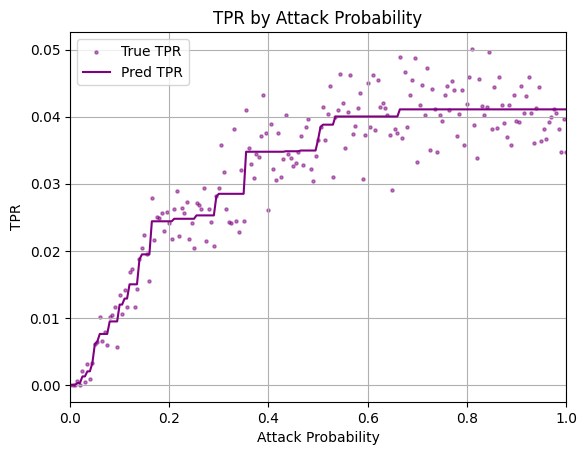

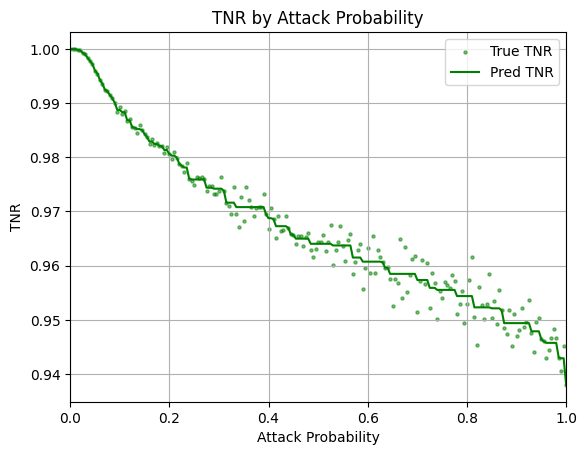

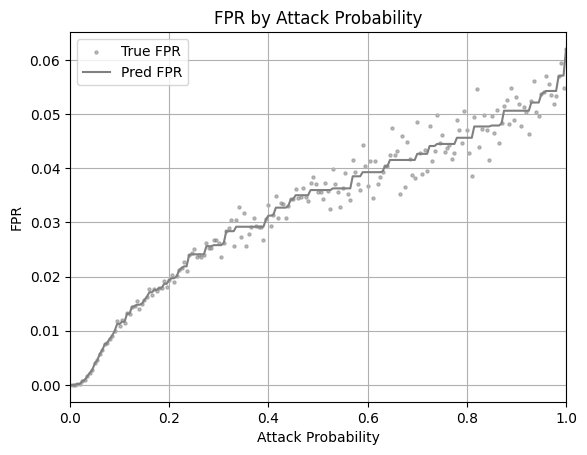

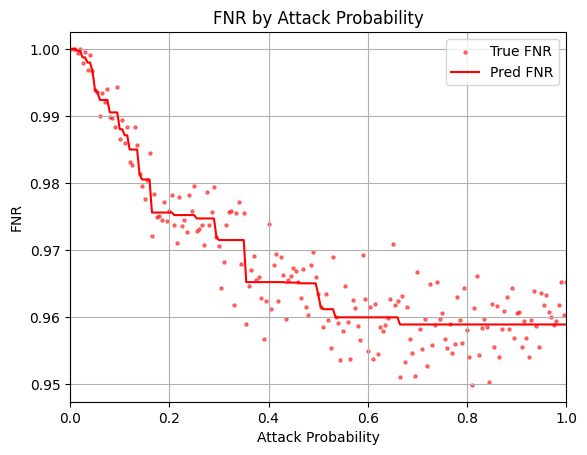

In [ ]:
for func, color in zip(ATTACK_PROBABILITY_FUNCTIONS, COLORS):
    plt.scatter(
        df_random["attack_probability"],
        df_random[func.column],
        label=f"True {func.column}",
        s=5,
        color=color,
        alpha=0.5,
    )
    y = np.array(list(map(func, df_random["attack_probability"])))
    plt.plot(
        df_random["attack_probability"],
        y,
        label=f"Pred {func.column}",
        color=color,
    )
    plt.xlim(0, 1)
    plt.xlabel("Attack Probability")
    plt.ylabel(func.column)
    plt.title(f"{func.column} by Attack Probability")
    plt.legend()
    plt.grid(visible=True)
    plt.show()

### Functions (Markov chain)

$m = max\ step$

$a = attack\  probability$

$i = innactivity\  probability$

$u = probability\ of\ loosing\ control$

$c = probability\ of\ keeping\ control$

$h = FNR\ of\ detection\ model$

$d = TPR\ of\ detection\ model$

$e = FPR\ of\ detection \ model$

$w = TNR\ of\ detection \ model$

$ R = \begin{bmatrix}
1 & 0 & 0
\end{bmatrix}$

$P = \begin{bmatrix}
ahwu + iwu + iwc & ahwc & ad + ahe + ie\\
ahwu + iwu & ahwc + iwc & ad + ahe + ie\\
0 & 0 & 1
\end{bmatrix}$

$C = \begin{bmatrix}
ahwc\\
ahwc + iwc\\
0
\end{bmatrix}$

$ A = \begin{bmatrix}
a\\
a\\
0
\end{bmatrix}$

$S = \begin{bmatrix}
1\\
1\\
0
\end{bmatrix}$

$T = R(\sum_{n=1}^{m} P^n)$

$\mathbb{E}[control\ count] = TC$

$\mathbb{E}[attack\ count] = TA$

$\mathbb{E}[step] = TS$

$\mathbb{E}[survability] = \frac{\mathbb{E}[step]}{m}$

$\mathbb{E}[domination] = \frac{\mathbb{E}[control\ count]}{\mathbb{E}[step]}$


In [ ]:
def expected_controlled_messages(
    attack_prob: float,
) -> tuple[float, float, float]:
    """Expected value of the number of controlled messages"""
    a = attack_prob
    u = UNCONTROL_PROB
    d = ATTACK_PROBABILITY_TPR(attack_prob)
    e = ATTACK_PROBABILITY_FPR(attack_prob)
    i = 1 - a
    c = 1 - u
    h = 1 - d
    w = 1 - e
    current = np.array([1.0, 0.0, 0.0], dtype=np.float64)
    mat = np.array(
        [
            [
                a * h * w * u + i * w * u + i * w * c,
                a * h * w * c,
                a * d + a * h * e + i * e,
            ],
            [
                a * h * w * u + i * w * u,
                a * h * w * c + i * w * c,
                a * d + a * h * e + i * e,
            ],
            [0.0, 0.0, 1.0],
        ],
        dtype=np.float64,
    )
    control_mat = np.array(
        [[a * h * c, a * h * c + i * c, 0.0]], dtype=np.float64
    )
    attack_mat = np.array([[a, a, 0.0]], dtype=np.float64)
    step_mat = np.array([[1.0, 1.0, 0.0]], dtype=np.float64)

    prob = np.sum(np.linalg.matrix_power(mat, n) for n in range(MAX_STEP))
    superposed_states = current.dot(prob)
    control = superposed_states.dot(control_mat.T)
    attack = superposed_states.dot(attack_mat.T)
    step = superposed_states.dot(step_mat.T)
    return attack, control, step


def expected_domination(
    attack_prob: float,
) -> float:
    """Expected value of the domination based on attack probability."""
    attack, control, step = expected_controlled_messages(attack_prob)
    return control / step


def expected_survivability(attack_prob: float) -> float:
    """Expected value of the survivability based on attack probability."""
    attack, control, step = expected_controlled_messages(attack_prob)
    return step / MAX_STEP

### Plot result

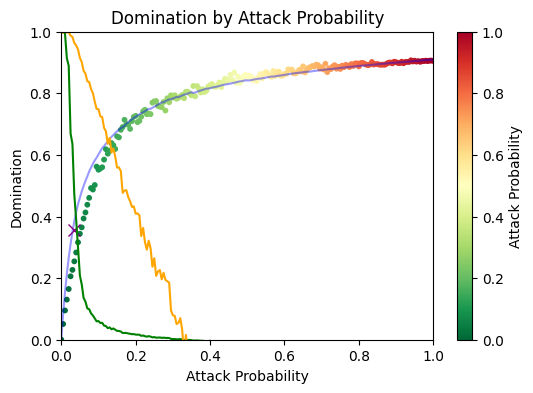

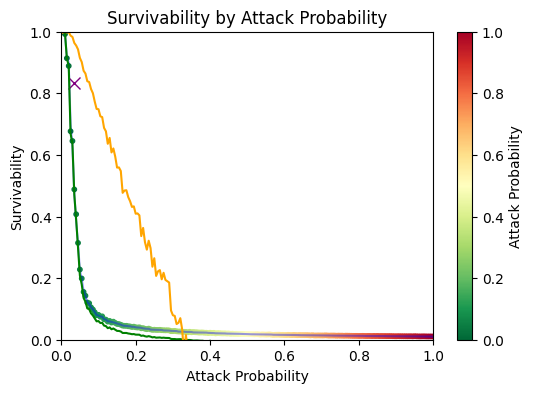

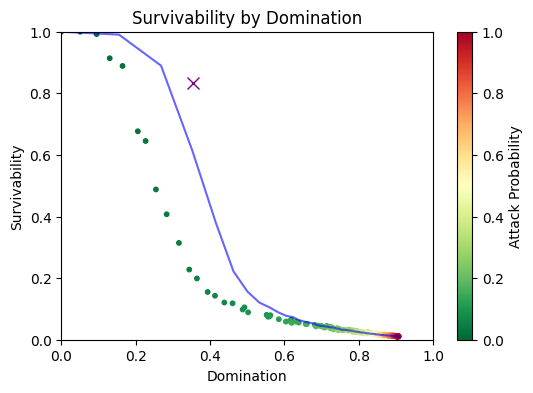

In [ ]:
def pair_plot(c1: str, c2: str, f1=None, f2=None) -> None:
    """Show pair plot."""
    # Plotting x vs. y using the index of the DataFrame
    plt.figure(figsize=(6, 4))
    if f1 is None:
        pass
    elif f2 is None:
        plt.plot(
            df_random[c1],
            np.array(list(map(f1, df_random[c1]))),
            label="Curve",
            color="blue",
            alpha=0.4,
        )
    else:
        x = np.linspace(0, 1, 100)
        px = np.array(list(map(f1, x)))
        py = np.array(list(map(f2, x)))
        plt.plot(px, py, label="Curve", color="blue", alpha=0.6)

    plt.scatter(
        df_random[c1],
        df_random[c2],
        c=df_random["attack_probability"],
        label="Ratio",
        alpha=1,
        cmap="RdYlGn_r",
        s=10,
    )
    if "df_test" in globals():
        df_test["attack_probability"] = df_test["aggressivity"]
        plt.plot(
            df_test[c1],
            df_test[c2],
            marker="x",
            color="purple",
            label="Final Score",
            markersize=8,
        )

    # Labels and title
    x_label = c1.title().replace("_", " ")
    y_label = c2.title().replace("_", " ")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{y_label} by {x_label}")
    plt.colorbar(label="Attack Probability")


reward = (
    df_random["alive"] * parameters["env"]["alive_reward"]
    + df_random["step"] * parameters["env"]["survive_reward"]
    + df_random["attack_count"] * parameters["env"]["control_reward"]
    + df_random["attack_count"] * parameters["env"]["attack_reward"]
    - df_random["detected"] * parameters["env"]["detected_penalty"]
    - df_random["error_attack"] * parameters["env"]["error_penalty"]
    - df_random["error_idle"] * parameters["env"]["error_penalty"]
    - df_random["noise_count"] * parameters["env"]["noise_penalty"]
)
reward_ratio = reward / reward.max()

reward_per_step = reward / df_random["step"]
reward_per_step_ratio = reward_per_step / reward_per_step.max()

with np.errstate(divide="ignore"):
    pair_plot("attack_probability", "domination", expected_domination)
    plt.plot(
        df_random["attack_probability"],
        reward_ratio,
        label="Reward",
        color="green",
    )
    plt.plot(
        df_random["attack_probability"],
        reward_per_step_ratio,
        label="Reward per step",
        color="orange",
    )
    plt.show()

    pair_plot("attack_probability", "survivability", expected_survivability)
    plt.plot(
        df_random["attack_probability"],
        reward_ratio,
        label="Reward",
        color="green",
    )
    plt.plot(
        df_random["attack_probability"],
        reward_per_step_ratio,
        label="Reward per step",
        color="orange",
    )
    plt.show()

    pair_plot(
        "domination",
        "survivability",
        expected_domination,
        expected_survivability,
    )
    plt.show()